***RNN using PyTorch***



---



This example illustrates the implementation of Recurrent Neural Networks (RNN) in PyTorch. Here the RNN model is built for time series prediction using a cosine function with harmonics or a filtered noise.  


**Importing packages, setting the parameters and loading dataset**

The first step consists of importing the PyTorch libraries and other necessary packages.

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Parameters of the experiment
train_data_size=250
test_data_size=100
data_size=train_data_size+test_data_size
num_epochs = 200
learning_rate = 0.001
sigma=0.002 # Noise standard deviation
window_length = 10   #Length of the RNN window
h=5 #Prediction horizon
input_size = 1
hidden_size = 100
num_layers = 2
num_classes = 1
batch_size = 64

###**Defining the input to the model**###

The RNN in this example is built to perform one step-ahead prediction of a time series. There are two implemented signals. The first one is a harmonic signal with the expression

\begin{equation}
    x[t] = \cos\left[\frac{\pi}{6} t\right]  + \frac{1}{2}\cos\left[\frac{\pi}{3} t\right] + \frac{1}{2}\cos\left[\frac{2\pi}{3} t\right] + g[t]
\end{equation}
for $0 \leq t \leq 200$, and where $g[n]$ is an additive Gaussian noise of independent and identically distributed samples with standard deviation $\sigma=$ defined above.

The second one is a sequence of independent and identically distributed Gaussian samples filtered with a Butterworth low pass filter of order 4 and lowpass frequency $\Omega=0.1 ~rad.$

In [ ]:
from scipy.signal import butter,filtfilt

def data(type,N):
  if type=='harmonics':
    t = np.pi*torch.linspace(0,data_size-1,data_size)/6
    y_ = (torch.cos(t) + torch.cos(2*t)/2 + torch.cos(4*t)/4)
  elif type == 'low_pass':
    u = np.random.randn(data_size)
    b, a = butter(4, 0.1, btype='low', analog=False)
    y_ = np.copy(filtfilt(b, a, u))
    y_=torch.Tensor(y_)
  y = y_ + sigma*torch.randn(data_size)
  return y, y_

#y, y_ = data('harmonics',data_size)
y, y_ = data('low_pass',data_size)

##**Visualizing the data**##

Now lets visualize the function and plot the input data.

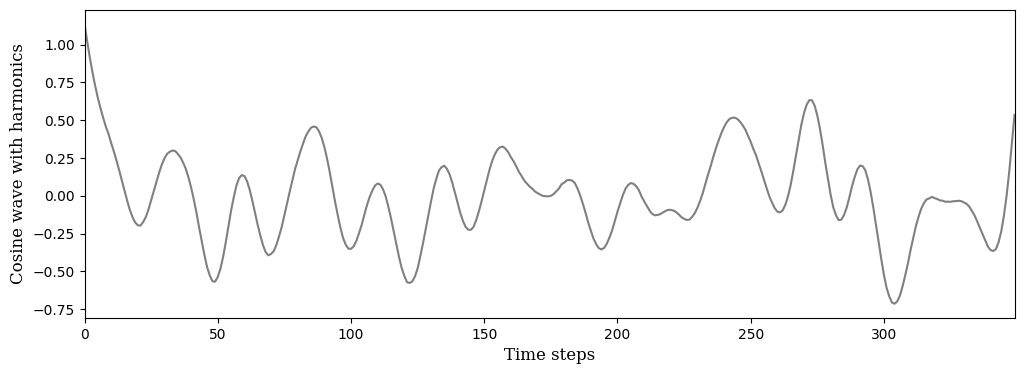

In [ ]:
plt.figure(figsize=(12,4))
csfont = {'fontname':'serif'}
plt.xlim(-1,201)
plt.plot(y.numpy(),'Grey')
plt.xlabel('Time steps',fontsize=12,**csfont)
plt.ylabel('Cosine wave with harmonics',fontsize=12,**csfont)
plt.autoscale(axis='x',tight=True)
plt.savefig('cos.pdf')
plt.show()



In this step the data is extracted and divided into training and test. The data is divided into 150 samples for training and 50 for testing. Following this feature normalization is performed using the MinMaxScaler() function and the data is scaled between 0 and 1.

In [ ]:
train_data = y[:-test_data_size]
test_data = y[-test_data_size:]
train_data=train_data.reshape(-1, 1)
test_data=test_data.reshape(-1, 1)

sc = MinMaxScaler(feature_range = (0, 1))
training_data = sc.fit_transform(train_data)
testing_data = sc.transform(test_data)

Here we define the sliding window for scanning the training and test data. We split the training sequence into overlapping windows while developing the RNN models. For example, if we have a sequence with 16 samples and a window size of 4, we can enter [x1, x2, x3, x4] into the model and compare the forecast to x5. Next we input [x2, x3, x4, x5] into the model and match the forecast to x6 and the process goes on. The sliding window is defined using a function that inputs the data and the sequence length. The output of the function returns the sequence and the corresponding labels.

**Define the sliding window**

In [ ]:
def sliding_windows(data, window_length,h=1):
    x = []
    y = []
    for i in range(len(data)-window_length-h+1):
        _x = data[i:(i+window_length)]
        _y = data[i+window_length+h-1]
        x.append(_x)
        y.append(_y)
        A=np.shape(x)
    return np.reshape(x,(A[0], A[1], A[2])), y

x, y = sliding_windows(training_data, window_length,h)
x1, y1 = sliding_windows(testing_data, window_length,h)
trainX = Variable(torch.Tensor(np.array(x)))
trainY = Variable(torch.Tensor(np.array(y)))
testX = Variable(torch.Tensor(np.array(x1)))
testY = Variable(torch.Tensor(np.array(y1)))

train_dataset = TensorDataset(trainX, trainY)
test_dataset  = TensorDataset(testX, testY)

train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)
print(trainX.shape,trainY.shape)
print(testX.shape,testY.shape)


torch.Size([236, 10, 1]) torch.Size([236, 1])
torch.Size([86, 10, 1]) torch.Size([86, 1])


In [ ]:
x1, y1 = sliding_windows(torch.arange(20).reshape(20,1), 3,h)
print(x1.T)
print(y1)

[[[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
  [ 2  3  4  5  6  7  8  9 10 11 12 13 14]]]
[tensor([7]), tensor([8]), tensor([9]), tensor([10]), tensor([11]), tensor([12]), tensor([13]), tensor([14]), tensor([15]), tensor([16]), tensor([17]), tensor([18]), tensor([19])]


The RNN architecture is defined as a class that consists of 1 RNN layer and a fully-connected layer.

**RNN model architecture**

In [ ]:
class RNN(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()

        self.num_classes = num_classes # the number of output time steps.
        self.num_layers = num_layers #the number of recurrent layers.
        self.input_size = input_size # the number of expected features in the input.
        self.hidden_size = hidden_size # the number of features in the hidden state h.

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, nonlinearity='tanh')
        #If batch_first is True, then the input and output tensors are provided as (batch, seq, feature).

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) # initialize hidden state.
        h_x, h_out = self.rnn(x, h_0)
        #h_out = h_x.view(-1, self.hidden_size)
        h_out1=h_x[:, -1, :] # reshape the output into (batch_size*seq_length, hidden_size).
        out = self.fc(h_out1)

        return out

In the training, we construct a for loop for performing the gradient descent and backpropagation. In the first step we compute the forward pass through the network by applying the model to the training examples. Next the loss is calculated based on the defined loss function, which compares the model output to the actual training labels. The .backward() function is used to backpropagate the derivative of the loss with respect to the model parameters through the network. After setting the current parameter gradients to zero with .zero_grad(), we update the model parameters by subtracting the gradient times the learning rate. This is done with the optimizer, using optimizer.step(). Here we use the Adam optimizer and mean square error loss for optimization.

**Training of the RNN**

In [ ]:
rnn = RNN(num_classes, input_size, hidden_size, num_layers)
print(rnn)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
loss_curve=[]
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    loss_total = 0
    outputs = rnn(images)
    optimizer.zero_grad()
    loss = criterion(outputs,labels)
    loss_total += loss.item()
    loss.backward()

    optimizer.step()
    loss_curve.append(loss_total)
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

RNN(
  (rnn): RNN(1, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)
Epoch: 0, loss: 0.02022
Epoch: 100, loss: 0.00216


**Plotting the loss curve for the training data**

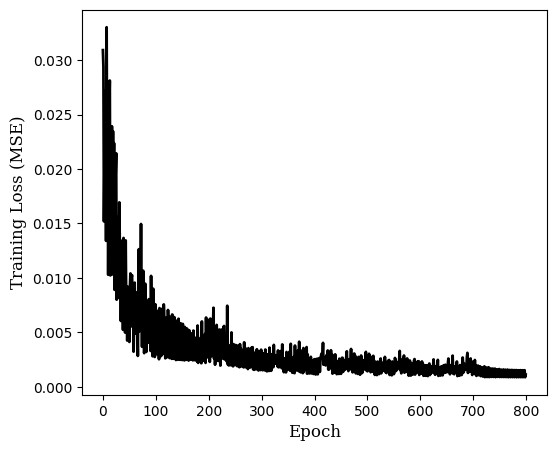

In [ ]:
plt.figure(figsize=(6,5))
csfont = {'fontname':'serif'}
plt.plot(loss_curve, lw=2,color='k')
plt.xlabel("Epoch",fontsize=12,**csfont)
plt.ylabel("Training Loss (MSE)",fontsize=12,**csfont)
plt.savefig('loss_rnn.pdf')
plt.show()

**Predictions on the test data**

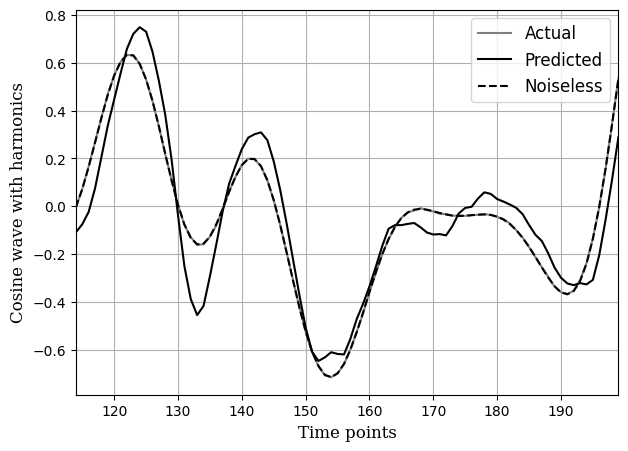

In [ ]:
rnn.eval()
test_predict = rnn(testX)
data_predict = test_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
plt.figure(figsize=(7,5))
x = np.arange(200-dataY_plot.size,200, 1)
csfont = {'fontname':'serif'}
plt.plot(x,dataY_plot,color='Grey',label='Actual')
plt.plot(x,data_predict,color='Black',label='Predicted')
plt.plot(x, y_[-test_predict.size()[0]:], color='Black',linestyle='dashed',label='Noiseless')
plt.xlabel('Time points',fontsize=12,**csfont)
plt.ylabel('Cosine wave with harmonics',fontsize=12,**csfont)
plt.autoscale(axis='x',tight=True)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('Output_rnn.pdf')
plt.show()
